In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pralabhpoudel/world-energy-consumption")

print("Path to dataset files:", path)

df =path




100%|██████████| 2.25M/2.25M [00:00<00:00, 132MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/pralabhpoudel/world-energy-consumption/versions/3


In [8]:
import os, pandas as pd

print("PATH:", path)
print("Archivos en la carpeta Kaggle:", os.listdir(path))

# Intenta detectar automáticamente el CSV principal
csvs = [f for f in os.listdir(path) if f.lower().endswith(".csv")]
print("CSV candidates:", csvs)

if csvs:
    sizes = [(f, os.path.getsize(os.path.join(path, f))) for f in csvs]
    sizes.sort(key=lambda x: x[1], reverse=True)
    main_csv = sizes[0][0]
    print("Usando CSV:", main_csv)
    df = pd.read_csv(os.path.join(path, main_csv))
else:
    raise FileNotFoundError("No se encontraron CSV en la carpeta descargada.")

print(type(df))
print(df.head(3))
print(df.columns.tolist())


PATH: /root/.cache/kagglehub/datasets/pralabhpoudel/world-energy-consumption/versions/3
Archivos en la carpeta Kaggle: ['World Energy Consumption.csv']
CSV candidates: ['World Energy Consumption.csv']
Usando CSV: World Energy Consumption.csv
<class 'pandas.core.frame.DataFrame'>
         country  year iso_code  population  gdp  biofuel_cons_change_pct  \
0  ASEAN (Ember)  2000      NaN         NaN  NaN                      NaN   
1  ASEAN (Ember)  2001      NaN         NaN  NaN                      NaN   
2  ASEAN (Ember)  2002      NaN         NaN  NaN                      NaN   

   biofuel_cons_change_twh  biofuel_cons_per_capita  biofuel_consumption  \
0                      NaN                      NaN                  NaN   
1                      NaN                      NaN                  NaN   
2                      NaN                      NaN                  NaN   

   biofuel_elec_per_capita  ...  solar_share_elec  solar_share_energy  \
0                      NaN  ...  

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Filtramos a países reales (códigos ISO-3) y orden temporal
df_c = df[df['iso_code'].astype(str).str.len()==3].copy()
df_c = df_c.sort_values('year')

# Elegimos métrica robusta disponible
candidates = [
    'primary_energy_consumption',
    'energy_consumption',
    'electricity_generation'
]
ycol = next((c for c in candidates if c in df_c.columns), None)
print("Usando métrica:", ycol)


Usando métrica: primary_energy_consumption


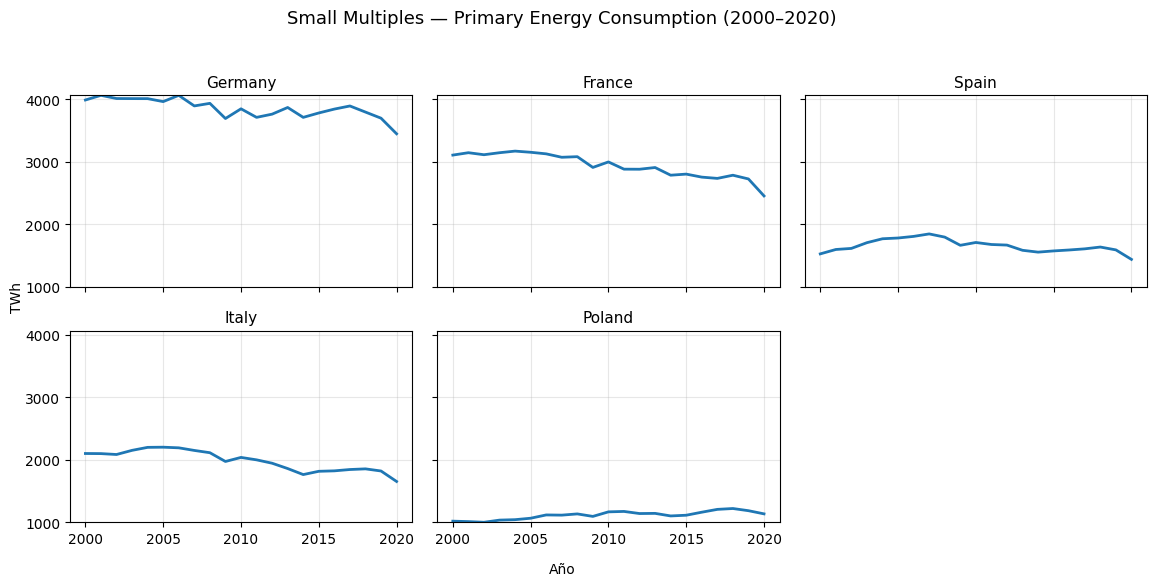

In [5]:
countries = ["Germany", "France", "Spain", "Italy", "Poland"]

sm = df_c[
    (df_c['country'].isin(countries)) &
    (df_c['year'].between(2000, 2020))
][['country','year',ycol]].dropna()

# Rango global para eje Y (comparabilidad)
ymin = sm[ycol].min()
ymax = sm[ycol].max()

# Subplots en rejilla
n = len(countries)
cols = 3
rows = int(np.ceil(n/cols))
fig, axes = plt.subplots(rows, cols, figsize=(12, 6), sharex=True, sharey=True)
axes = axes.flatten()

for i, cty in enumerate(countries):
    ax = axes[i]
    d = sm[sm['country']==cty]
    ax.plot(d['year'], d[ycol], linewidth=2)
    ax.set_title(cty, fontsize=11, pad=6)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(ymin, ymax)

# Ejes y títulos
for ax in axes:
    ax.label_outer()
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

fig.suptitle(f"Small Multiples — {ycol.replace('_',' ').title()} (2000–2020)", fontsize=13)
fig.text(0.5, 0.04, "Año", ha='center')
fig.text(0.04, 0.5, "TWh", va='center', rotation='vertical')

plt.tight_layout(rect=[0.04, 0.06, 1, 0.95])
plt.savefig("small_multiples.png", dpi=200, bbox_inches="tight")
plt.show()


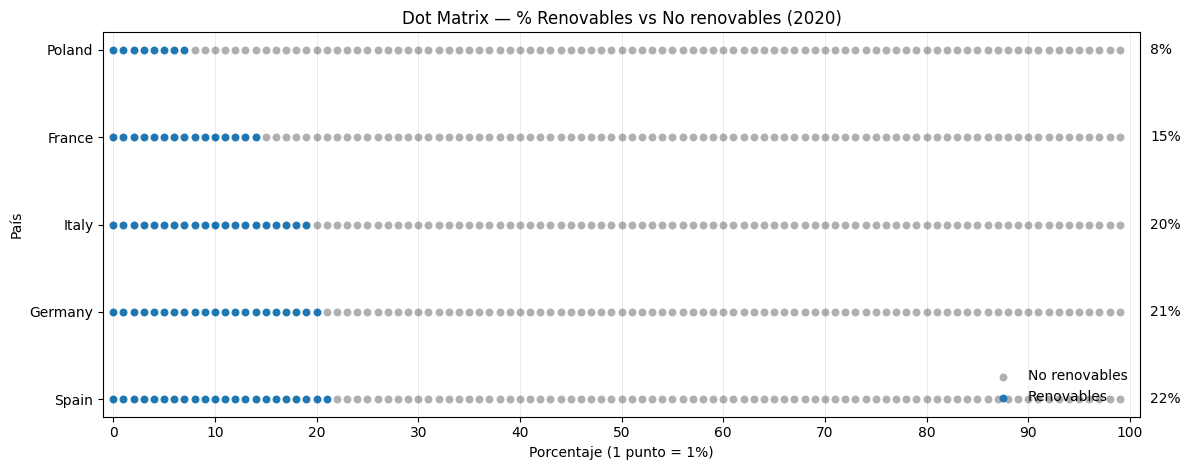

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtros básicos
countries = ["Germany", "France", "Spain", "Italy", "Poland"]
year_target = 2020

# Filtrar países reales (3 letras ISO)
df_c = df[df['iso_code'].astype(str).str.len() == 3].copy()

# Detectar columna de % renovables
share_candidates = ['renewables_share_energy', 'renewables_share_elec']
share_col = next((c for c in share_candidates if c in df_c.columns), None)
assert share_col is not None, f"No se encuentra ninguna de estas columnas: {share_candidates}"

# Filtrar año y países seleccionados
base = (
    df_c[(df_c['country'].isin(countries)) & (df_c['year'] == year_target)]
    [['country', share_col]]
    .dropna()
    .copy()
)

# Calcular % renovables y no renovables
base['renewable_pct'] = base[share_col].clip(0, 100).round().astype(int)
base['nonrenew_pct'] = (100 - base['renewable_pct']).astype(int)

# Ordenar de mayor a menor % renovables
base = base.sort_values('renewable_pct', ascending=False).reset_index(drop=True)

# Expandir a puntos unidad (1 punto = 1%)
rows = []
for i, r in base.iterrows():
    for k in range(100):
        cat = 'Renovables' if k < r['renewable_pct'] else 'No renovables'
        rows.append({'country': r['country'], 'row': i, 'x': k, 'cat': cat})
dot = pd.DataFrame(rows)

# Colores y estilo
color_map = {'No renovables': '#b0b0b0', 'Renovables': '#1f77b4'}

# Gráfico
fig, ax = plt.subplots(figsize=(12, 4.8))

for cat, dcat in dot.groupby('cat'):
    ax.scatter(dcat['x'], dcat['row'], s=22, c=color_map[cat], label=cat)

# Ejes y formato
ax.set_yticks(range(len(base)))
ax.set_yticklabels(base['country'])
ax.set_xlim(-1, 101)
ax.set_xticks(range(0, 101, 10))
ax.set_xlabel("Porcentaje (1 punto = 1%)")
ax.set_ylabel("País")
ax.set_title(f"Dot Matrix — % Renovables vs No renovables ({year_target})")

# Líneas guía cada 10%
for x in range(0, 101, 10):
    ax.axvline(x, color='k', linewidth=0.4, alpha=0.15)

# Anotar % renovables al final de cada fila
for i, r in base.iterrows():
    ax.text(102, i, f"{int(r['renewable_pct'])}%", va='center')

# Leyenda
ax.legend(frameon=False, loc='lower right')

plt.tight_layout()
plt.savefig("dot_matrix.png", dpi=220, bbox_inches="tight")
plt.show()


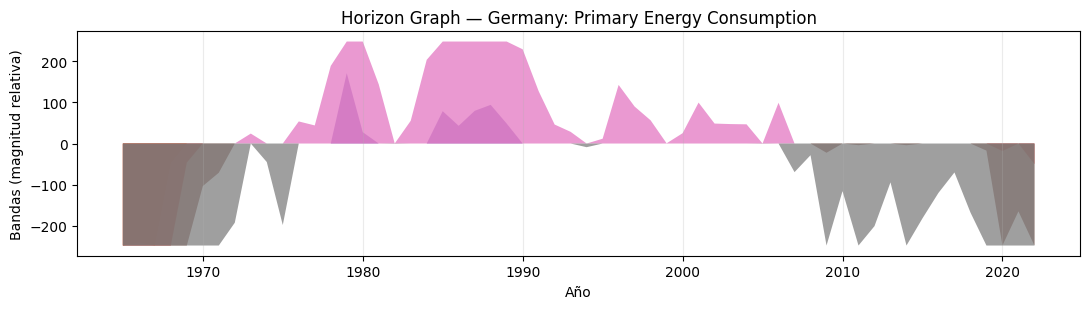

In [10]:
# HORIZON GRAPH — Consumo energético a lo largo del tiempo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parámetros editables
country_h = "Germany"   # país que quieras visualizar
bands = 4               # número de bandas por lado (3–5 es ideal)

# Asegurar países reales (ISO-3)
df_c = df[df['iso_code'].astype(str).str.len() == 3].copy()

# Elegir métrica disponible (orden de preferencia)
candidates = [
    'primary_energy_consumption',   # suele estar en TWh
    'energy_consumption',
    'electricity_generation'
]
ycol = next((c for c in candidates if c in df_c.columns), None)
assert ycol is not None, f"No se encontró ninguna de las columnas esperadas: {candidates}"

# Filtrar datos del país
s = (
    df_c[df_c['country'] == country_h][['year', ycol]]
    .dropna()
    .sort_values('year')
)
assert not s.empty, f"No hay datos para {country_h} en {ycol}"

years = s['year'].astype(int).values
vals = s[ycol].values

# Centrar datos para resaltar variaciones relativas
vals_centered = vals - np.nanmedian(vals)

# Calcular altura de banda
max_abs = np.nanmax(np.abs(vals_centered))
if max_abs == 0:
    max_abs = 1.0
band_h = max_abs / bands

# Crear gráfico
plt.figure(figsize=(11, 3.2))

# Dibujar bandas positivas y negativas superpuestas
for b in range(bands, 0, -1):
    # Banda positiva
    top = np.clip(vals_centered, (b - 1) * band_h, b * band_h) - (b - 1) * band_h
    # Banda negativa
    bot = -np.clip(-vals_centered, (b - 1) * band_h, b * band_h) + (b - 1) * band_h
    plt.fill_between(years, 0, top, alpha=0.75)
    plt.fill_between(years, bot, 0, alpha=0.75)

plt.title(f"Horizon Graph — {country_h}: {ycol.replace('_',' ').title()}")
plt.xlabel("Año")
plt.ylabel("Bandas (magnitud relativa)")
plt.grid(axis='x', alpha=0.25)
plt.tight_layout()
plt.savefig("horizon_graph.png", dpi=220, bbox_inches="tight")
plt.show()
